In [79]:
# Load standard python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from textblob import TextBlob
import re
import spacy
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


# Set the path to find my dataprocessing functions
import sys
sys.path.append('./preprocessing')

# Load custom libraries
from vectorization import save_vectorizer, load_vectorizer, save_sparse_matrix, load_sparse_matrix
from inflation import load_cpi_data, adjust_for_inflation, undo_inflation_adjustment
from feature_engineering import standardize_dates, engineer_features
from text_cleaning import preprocess_claim_description

In [101]:
df = pd.read_csv('Data/inflation.csv', index_col= 'ClaimNumber')

df

,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost,HoursWorkedPerDay,ReportingDelta
ClaimNumber,,,,,,,,,,,,,,,,
WC8285054,2002-04-09 07:00:00+00:00,2002-07,48,M,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,2646.691667,8378.020226,7.6,86
WC6982224,1999-01-07 11:00:00+00:00,1999-01,43,F,M,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,10606.050395,12199.437492,7.5,12
WC5481426,1996-03-25 00:00:00+00:00,1996-04,30,M,U,0,0,709.10,F,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,3458.841127,4667.297321,7.6,20
WC9775968,2005-06-22 13:00:00+00:00,2005-07,41,M,S,0,0,555.46,F,38.0,5,DIGGING LOWER BACK LOWER BACK STRAIN,24443.535146,28984.308285,7.6,29
WC2634037,1990-08-29 08:00:00+00:00,1990-09,36,M,M,0,0,377.10,F,38.0,5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,6711.610566,9621.580158,7.6,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WC9370727,2004-08-21 18:00:00+00:00,2004-09,32,F,S,0,0,500.00,F,38.0,5,STRUCK KNIFE LACERATED LEFT MIDDLE FINGER LEFT...,1673.356164,804.036440,7.6,17
WC8396269,2002-04-28 09:00:00+00:00,2002-09,20,F,S,0,0,500.00,F,40.0,5,LEFT HAND LACERATION LEFT SIDE BACK AND LEFT LEG,1756.653761,1327.565290,8.0,127
WC3609528,1992-02-28 09:00:00+00:00,1992-03,19,M,S,0,0,283.00,F,40.0,5,METAL SLIPPED ACROSS METAL CUT FINGER,479.486916,954.814764,8.0,18


The feature engineering of claims information is the most challenging part of this analysis. The claim information column contains free text descriptions of the incident with text such as the following: 'LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY', 'REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STRAIN LEFT SIDE OF STOMACH', 'CUTTING DOWN A SMALL STEP SPRAINED TWISTED RIGHT FOOT', and 'STRIKING AGAINST FORKLIFT PRONGS BRUISED RIGHT RING FINGER'. These descriptions follow the rough format of method of injury, location of injury, and injury type. One issue however is that not all 3 elements of this information are included in every description and the descriptions are not laid out in a format that makes extraction of this information easy. One method to engineer new columns from this information would be to manually read through the claims information and try to create categories such as lifting, stepping, or struck. But there are 54,000 observations making this task extremely inefficient and unlike to generalize well to unseen data.

Instead I will manually tag a small subset of rows, and use natural language processing (NLP) to learn patterns based on that subset.

In [81]:
print(df['ClaimDescription'].value_counts().head(30).reset_index())

                                     ClaimDescription  count
0         SLIPPED ON ROLLER TENDONITIS RIGHT SHOULDER    289
1         SORTING ALUMINIUM BARS STRAIN SHOULDER NECK    278
2                   SLIPPED USING LATHE IN EYE CORNEA    258
3       REDBACK SPIDER BITE RIGHT FOOT RIGHT FRACTURE    256
4                     LIFTING TYRES LOWER BACK STRAIN    255
5               LIFTING BACK STRAIN LOWER BACK STRAIN    253
6                        FELL DOWN STAIRS BACK SPRAIN    236
7                          HIT AIR HOSE LACERATED LIP    233
8          JAMMED RIGHT HAND PUNCTURE WOUND RIGHT ARM    231
9              USING AIR HOSE STRAIN RIGHT KNEE RIGHT    229
10  CLEANING INSTRUMENTS LEFT THUMB PENETRATING IN...    218
11        KNIFE LACERATION LEFT HAND BRUISING TO FACE    206
12   FRACTURED LEFT WRIST FRACTURE LEFT MIDDLE FINGER    204
13  WHILE DEALING CARDS RIGHT TENDON SYNOVITIS RIG...    197
14   GRINDING STEEL BEAM INFECTION LEFT LEFT SHOULDER    189
15  SLIPPED ON STAIRS RI

The top 30 rows sorted by unique values represents 5992 of the 54,000 observations in the data. But manually tagging and learning proved to be no better than just trying to tag all rows.

This approach will use a fully NLP machine learning approach in python. The first step before fitting models to derive new features from the free text column is to preprocess the data. It needs to be standardized by putting all info in the same case, removing punctuation, stripping any whitespace present and lemmatizing the data so that only the root of each word is used. This is important so that lacerate and lacerated are treated equally by the classifier.

In [82]:
# functions for standardizing textual information

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'[\d\W]+', ' ', text)  # remove digits and non-word chars
    text = text.strip()
    return text

def correct_spelling(text):
    corrected = TextBlob(text).correct()
    return str(corrected)

def lemmatize_text(text):
    doc = nlp(text)
    lemmas = []
    for token in doc:
        if token.text.lower() == "left":
            lemmas.append("left")
        else:
            lemmas.append(token.lemma_)
    return ' '.join(lemmas)

Context based lemmatization struggled with changing things like left to leave. Word based only would not change lower, leaving a bunch of lower back, and a bunch of low back. Word based with custom rules gave the most ideal results.

In [83]:
processed_sample = preprocess_claim_description(df.iloc[:49], col='ClaimDescription')
print(processed_sample)

ClaimNumber
WC8285054       lift tyre injury to right arm and wrist injury
WC6982224    step around crate and truck tray fracture left...
WC5481426                     cut on sharp edge cut left thumb
WC9775968                         dig low back low back strain
WC2634037    reach above shoulder level acute muscle strain...
WC6828422                    strike head on head lacerate head
WC8058150                   finger bruise and swollen left arm
WC7539849               clean left shoulder splinter left hand
WC4427179        jack slip catch finger cut left little finger
WC9907636        strike pine dust abrasion left eye irritation
WC3053943       strained muscle in back strained low back pain
WC6193926                              to right leg right knee
WC2826510                                  pick up parcel back
WC5428872                            strike timber right wrist
WC4129793                 empty bin fish bone foreign body eye
WC8342953             fall from a ladder st

In [84]:
df['ClaimDescription'] = preprocess_claim_description(df)

In [85]:
df

,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost,HoursWorkedPerDay,ReportingDelta
ClaimNumber,,,,,,,,,,,,,,,,
WC8285054,2002-04-09 07:00:00+00:00,2002-07,48,M,M,0,0,500.00,F,38.0,5,lift tyre injury to right arm and wrist injury,2646.691667,8378.020226,7.6,86
WC6982224,1999-01-07 11:00:00+00:00,1999-01,43,F,M,0,0,509.34,F,37.5,5,step around crate and truck tray fracture left...,10606.050395,12199.437492,7.5,12
WC5481426,1996-03-25 00:00:00+00:00,1996-04,30,M,U,0,0,709.10,F,38.0,5,cut on sharp edge cut left thumb,3458.841127,4667.297321,7.6,20
WC9775968,2005-06-22 13:00:00+00:00,2005-07,41,M,S,0,0,555.46,F,38.0,5,dig low back low back strain,24443.535146,28984.308285,7.6,29
WC2634037,1990-08-29 08:00:00+00:00,1990-09,36,M,M,0,0,377.10,F,38.0,5,reach above shoulder level acute muscle strain...,6711.610566,9621.580158,7.6,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WC9370727,2004-08-21 18:00:00+00:00,2004-09,32,F,S,0,0,500.00,F,38.0,5,strike knife lacerate left middle finger left ...,1673.356164,804.036440,7.6,17
WC8396269,2002-04-28 09:00:00+00:00,2002-09,20,F,S,0,0,500.00,F,40.0,5,left hand laceration left side back and left leg,1756.653761,1327.565290,8.0,127
WC3609528,1992-02-28 09:00:00+00:00,1992-03,19,M,S,0,0,283.00,F,40.0,5,metal slip across metal cut finger,479.486916,954.814764,8.0,18


In [86]:
df.to_csv('Data/NLP_cleaned.csv')

In [142]:
df = pd.read_csv('Data/NLP_cleaned.csv', index_col= 'ClaimNumber')
df

,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost,HoursWorkedPerDay,ReportingDelta
ClaimNumber,,,,,,,,,,,,,,,,
WC8285054,2002-04-09 07:00:00+00:00,2002-07,48,M,M,0,0,500.00,F,38.0,5,lift tyre injury to right arm and wrist injury,2646.691667,8378.020226,7.6,86
WC6982224,1999-01-07 11:00:00+00:00,1999-01,43,F,M,0,0,509.34,F,37.5,5,step around crate and truck tray fracture left...,10606.050395,12199.437492,7.5,12
WC5481426,1996-03-25 00:00:00+00:00,1996-04,30,M,U,0,0,709.10,F,38.0,5,cut on sharp edge cut left thumb,3458.841127,4667.297321,7.6,20
WC9775968,2005-06-22 13:00:00+00:00,2005-07,41,M,S,0,0,555.46,F,38.0,5,dig low back low back strain,24443.535146,28984.308285,7.6,29
WC2634037,1990-08-29 08:00:00+00:00,1990-09,36,M,M,0,0,377.10,F,38.0,5,reach above shoulder level acute muscle strain...,6711.610566,9621.580158,7.6,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WC9370727,2004-08-21 18:00:00+00:00,2004-09,32,F,S,0,0,500.00,F,38.0,5,strike knife lacerate left middle finger left ...,1673.356164,804.036440,7.6,17
WC8396269,2002-04-28 09:00:00+00:00,2002-09,20,F,S,0,0,500.00,F,40.0,5,left hand laceration left side back and left leg,1756.653761,1327.565290,8.0,127
WC3609528,1992-02-28 09:00:00+00:00,1992-03,19,M,S,0,0,283.00,F,40.0,5,metal slip across metal cut finger,479.486916,954.814764,8.0,18


In [ ]:
# 1. Load and clean the text data
claim_texts = df['ClaimDescription'].dropna().astype(str).tolist()

# 2. Tokenize: lowercase, strip non-alpha, and remove stopwords
def tokenize(text):
    words = re.findall(r'\b[a-z]{2,}\b', text.lower())
    return [word for word in words if word not in ENGLISH_STOP_WORDS]

# 3. Flatten all words across documents
all_tokens = []
for text in claim_texts:
    all_tokens.extend(tokenize(text))

# 4. Count frequency
word_counts = Counter(all_tokens)

# 5. Create a DataFrame of word counts
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

# 6. View top 20 words
print(word_freq_df.head(587))
word_freq_df

           Word  Frequency
0         right      22650
1          left      20756
2        strain      18178
3           low      10271
4        finger       9023
..          ...        ...
582  inhalation         26
583     syringe         26
584      worker         26
585     washing         26
586    suddenly         26

[587 rows x 2 columns]


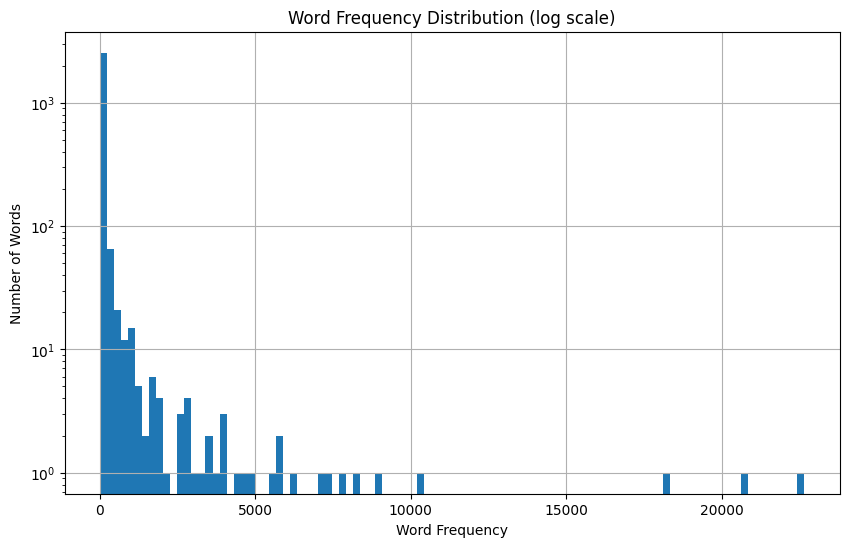

In [128]:
plt.figure(figsize=(10, 6))
plt.hist(word_freq_df['Frequency'], bins=100, log=True)
plt.title('Word Frequency Distribution (log scale)')
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.grid(True)
plt.show()

In [ ]:
tfidf = TfidfVectorizer(
    max_features=587,    # limit vocab size to control dimensionality
    ngram_range=(1,2),    # unigrams and bigrams to capture simple phrases (values larger than 2 did not improve performance)
    stop_words='english'  # remove common stopwords to reduce noise
)

X_tfidf = tfidf.fit_transform(df['ClaimDescription'])

# Save vectorizer and matrix
save_vectorizer(tfidf, 'tfidf_vectorizer.pkl')
save_sparse_matrix(X_tfidf, 'X_tfidf.npz')

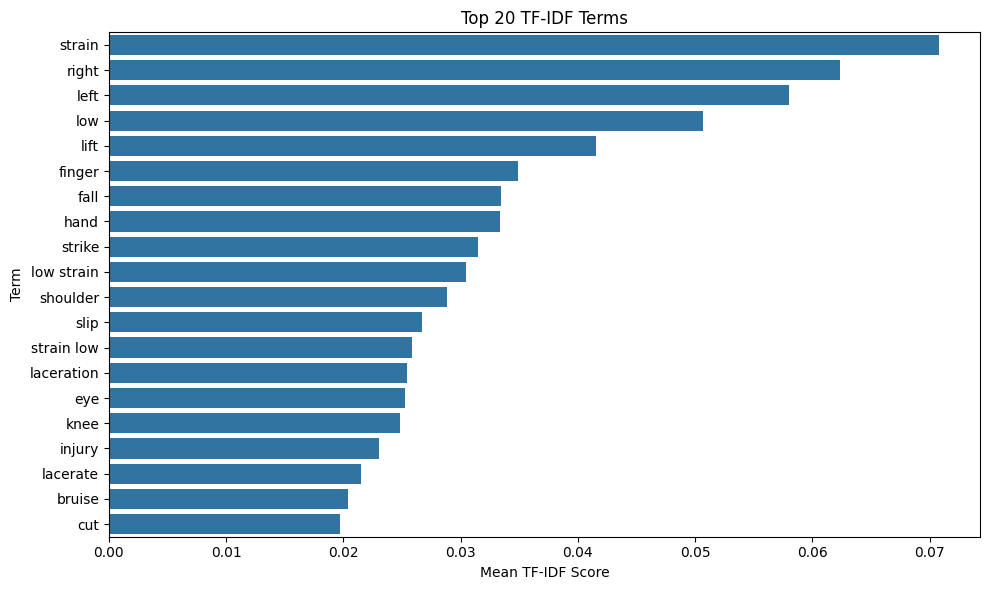

In [145]:
import numpy as np
import pandas as pd

# Get feature names and average TF-IDF scores
feature_array = np.array(tfidf.get_feature_names_out())
tfidf_scores = X_tfidf.mean(axis=0).A1  # mean TF-IDF score for each term

# Create and sort DataFrame
tfidf_df = pd.DataFrame({'term': feature_array, 'score': tfidf_scores})
tfidf_df = tfidf_df.sort_values(by='score', ascending=False)

# Plot top 20 terms
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='score', y='term', data=tfidf_df.head(20))
plt.title('Top 20 TF-IDF Terms')
plt.xlabel('Mean TF-IDF Score')
plt.ylabel('Term')
plt.tight_layout()
plt.show()

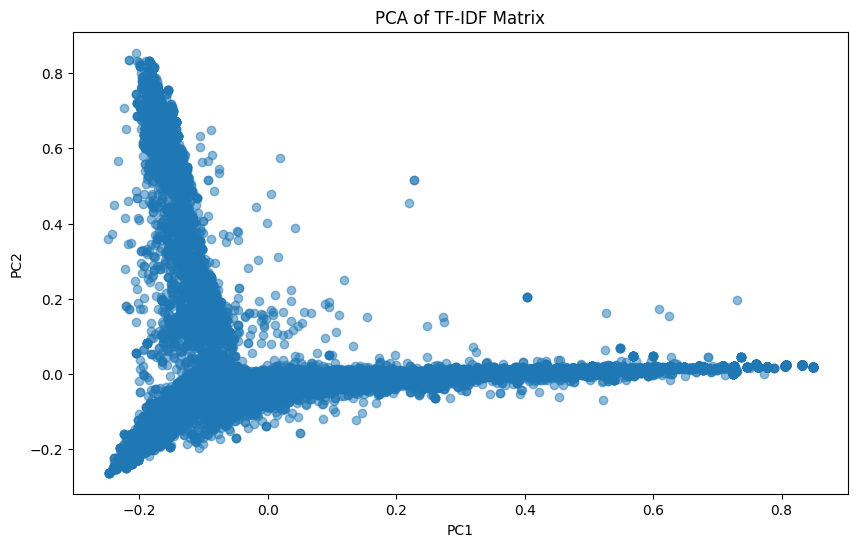

In [146]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('PCA of TF-IDF Matrix')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

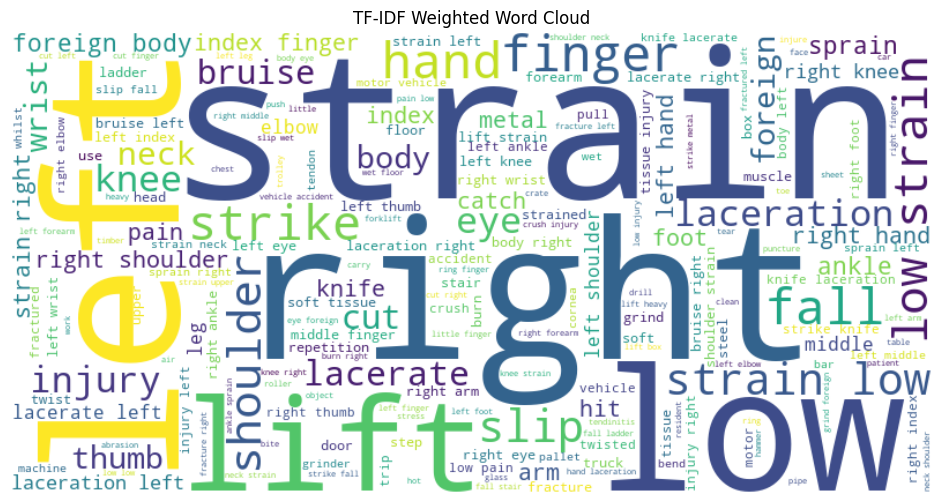

In [148]:
from wordcloud import WordCloud

# Build dictionary of term frequencies
word_scores = dict(zip(feature_array, tfidf_scores))

wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(word_scores)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('TF-IDF Weighted Word Cloud')
plt.show()